In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [4]:
def deg_to_rad(deg):
    return 2 * np.pi * deg / 360.0

def get_lat_diff(row, col, lat):
    #The latitude difference is the max difference from the surrounding pixels
    lat_diff = np.max([np.abs(lat[row - 1, col] - lat[row, col]), 
                      np.abs(lat[row + 1, col] - lat[row, col]), 
                      np.abs(lat[row, col + 1] - lat[row, col]), 
                      np.abs(lat[row, col - 1] - lat[row, col])])
    if lat_diff > 5: 
                    lat_diff = np.abs(180 - lat_diff)
    return lat_diff

def get_long_diff(row, col, long):
    #The latitude difference is the max difference from the surrounding pixels
    long_diff = np.max([np.abs(long[row - 1, col] - long[row, col]), 
                      np.abs(long[row + 1, col] - long[row, col]), 
                      np.abs(long[row, col + 1] - long[row, col]), 
                      np.abs(long[row, col - 1] - long[row, col])])
    if long_diff > 5: 
                    long_diff = np.abs(180 - long_diff)
    return long_diff
                             

#Calculates area, centroid coordinates, and aspect ratio for a given image in the Dataset/test/preds directory
def calc_metrics(im_num, verbose=False):
    im_name = os.listdir("../Dataset/test/preds")[im_num]
    pred_path = "../Dataset/test/preds/" + im_name
    if verbose:
        print("Calculating metrics for image", pred_path)
    data_path = "../Dataset/test/data/" + im_name[:-6] + ".npz"
    image_path = "../Dataset/test/images/" + im_name[:-6] + "_1_full.png"

    #each pixel has a height and width defined by lat and long, and then multiply that by a fraction of Titan's surface area 
    import time
    TITAN_RADIUS = 2575 #km
    titan_circumference = TITAN_RADIUS * 2 * np.pi
    
    #Read in the data and the predicted mask
    data = np.load(data_path)
    pred = cv2.imread(pred_path)[:, :, 0] / 255.0
    
    #Read these into memory to make looping faster
    lat = cv2.resize(data["lat"], dsize=(512, 512))
    long = cv2.resize(data["lon_w"], dsize=(512, 512))
    
    areas = np.zeros(lat.shape)
    
    threshold = 0.5
    pred = 1.0 * (pred > threshold)

    lat_diffs = np.zeros(lat.shape)
    long_diffs = np.zeros(lat.shape)
    
    ### AREA CALCULATION ###
    for row in range(1, lat.shape[0] - 1):
        for col in range(1, lat.shape[1] - 1):

            #Only calculate the area for where the predicted mask has values, and where we are looking at the surface of Titan
            if pred[row, col] > 0.5:
                lat_diff = get_lat_diff(row, col, lat)
                long_diff = get_long_diff(row, col, long)
                lat_diffs[row, col] = lat_diff
                long_diffs[row, col] = long_diff
        
                #Get height and width as fractions of diameters of titan slices at the given latitudes and longitudes
                height_slice_circ = np.abs(np.cos(deg_to_rad(long[row, col]))) * titan_circumference
                width_slice_circ = np.abs(np.cos(deg_to_rad(lat[row, col]))) * titan_circumference
                height = height_slice_circ * (lat_diff / 360.0)
                width = width_slice_circ * (long_diff / 360.0)
                area = height * width
                # if area > 1000:
                #     print("At lat and long", lat[row, col], long[row, col])
                #     print("Prev and post lats are", lat[row-1, col], lat[row+1,col])
                #     print("Prev and post longs are", long[row, col-1], long[row, col+1])
                #     print("Lat diff and long diff are", lat_diff, long_diff)
                #     print("Height slice circ is", height_slice_circ, "at long", long[row, col])
                #     print("Width slice circ is", width_slice_circ, "at lat", lat[row, col])
                #     print("Area is", area)
                #print("Got area", area, "at lat long", row, col)
                areas[row, col] = area
    
    ### CENTROID CALCULATION ###
    lat_center = 0
    long_center = 0
    area_sum = 0
    for row in range(1, areas.shape[0] - 1):
        for col in range(1, areas.shape[1] - 1):
            lat_center += areas[row, col] * (row)
            long_center += areas[row, col] * (col)
            area_sum += areas[row, col]
    lat_center = int(lat_center / area_sum)
    long_center = int(long_center / area_sum)
    lat_deg = lat[lat_center, long_center]
    long_deg = long[lat_center, long_center]

    ### ASPECT RATIO CALCULATION ###
    
    #first, find the greatest distance between any two points on the mask (major axis)
    max_dist = 0
    max_row1, max_col1, max_row2, max_col2 = 0, 0, 0, 0
    for row1 in range(1, areas.shape[0] - 1, 4):
        for col1 in range(1, areas.shape[1] - 1, 4):
            if pred[row1, col1] > 0.0:
                for row2 in range(1, areas.shape[0] - 1, 2):
                    for col2 in range(1, areas.shape[1] - 1, 2):
                        if pred[row2, col2] > 0.0:
                            this_dist = np.sqrt(np.power(row1 - row2, 2) + np.power(col1 - col2, 2))
                            if this_dist > max_dist:
                                max_row1 = row1
                                max_row2 = row2
                                max_col1 = col1
                                max_col2 = col2
                                max_dist = this_dist
    #print("Major axis is at (%d, %d) and (%d, %d)" % (max_row1, max_col1, max_row2, max_col2))
    major_slope = float(max_row1 - max_row2) / (max_col1 - max_col2 + 0.01)
    if major_slope == 0:
        major_slope = 1
    #print("Major slope is", major_slope)
    minor_slope = -1.0 / major_slope
    #print("Minor slope is", minor_slope)
    major_axis_length = np.sqrt(np.power(max_row1 - max_row2, 2) + np.power(max_col1 - max_col2, 2))
    #cv2.line(pred, (max_row1, max_col1), (max_row2, max_col2), (0, 255, 0))

    #Loop through again, but only care about the points that are on the minor axis
    max_row1, max_col1, max_row2, max_col2 = 0, 0, 0, 0
    max_dist = 0
    for row1 in range(1, areas.shape[0] - 1, 4):
        for col1 in range(1, areas.shape[1] - 1, 4):
            if pred[row1, col1] > 0.0:
                for row2 in range(1, areas.shape[0] - 1, 2):
                    for col2 in range(1, areas.shape[1] - 1, 2):
                        if pred[row2, col2] > 0.0 and np.abs(float(row1 - row2) / (col1 - col2 + 0.01) - minor_slope) < np.abs(0.5 * minor_slope):
                            this_dist = np.sqrt(np.power(row1 - row2, 2) + np.power(col1 - col2, 2))
                            if this_dist > max_dist:
                                max_row1 = row1
                                max_row2 = row2
                                max_col1 = col1
                                max_col2 = col2
                                max_dist = this_dist
    #print("Minor axis is at (%d, %d) and (%d, %d)" % (max_row1, max_col1, max_row2, max_col2))
    minor_axis_length = np.sqrt(np.power(max_row1 - max_row2, 2) + np.power(max_col1 - max_col2, 2))
    #cv2.line(pred, (max_row1, max_col1), (max_row2, max_col2), (0, 255, 0))
    asp_ratio = major_axis_length / minor_axis_length

    # min_x = 1000
    # max_x = 0
    # min_y = 1000
    # max_y = 0
    # for row in range(1, areas.shape[0] - 1):
    #     for col in range(1, areas.shape[1] - 1):
    #         if pred[row, col] > 0.0:
    #             if row < min_y:
    #                 min_y = row
    #             if row > max_y:
    #                 max_y = row
    #             if col < min_x:
    #                 min_x = col
    #             if col > max_x:
    #                 max_x = col
    # asp_ratio = (max_y - min_y) / (max_x - min_x)

    if verbose:
        print("Area is", round(np.sum(areas),2), "km^2")
        print("Centroid is pixel (%d, %d)" % (lat_center, long_center))
        print("Aspect Ratio is %0.3f" % asp_ratio)
        plt.imshow(pred)
        plt.matshow(areas)
        plt.matshow(cv2.imread(image_path))
        plt.matshow(lat)
        plt.matshow(long)
        plt.matshow(long_diffs)
    return round(np.sum(areas), 2), lat_deg, long_deg, round(asp_ratio, 3)


Calculating metrics for image ../Dataset/test/preds/N1872917556_1.png


C:\Users\zacha\AppData\Local\Temp\ipykernel_119384\3372304175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  asp_ratio = major_axis_length / minor_axis_length


Area is 1029203.39 km^2
Centroid is pixel (165, 101)
Aspect Ratio is inf


(1029203.39, 58.64945030687656, 1.1624339753527764, inf)

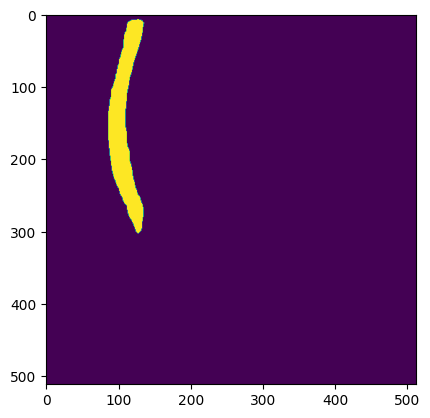

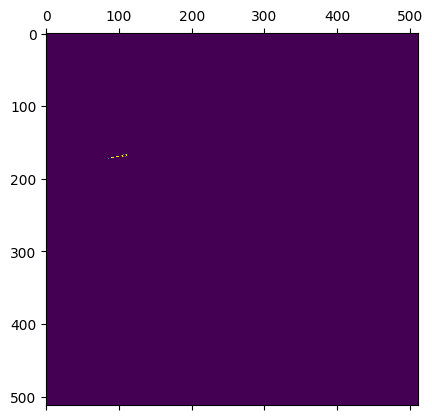

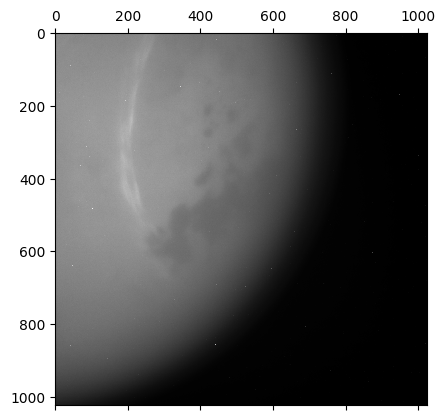

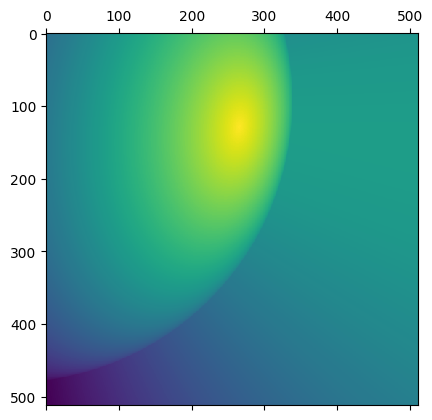

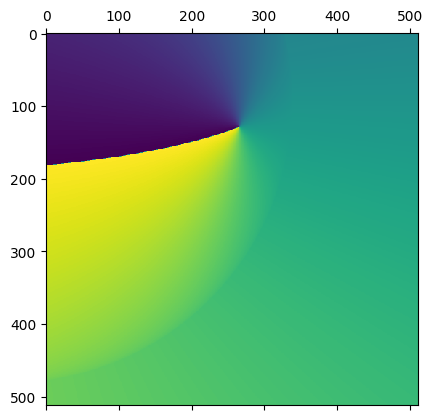

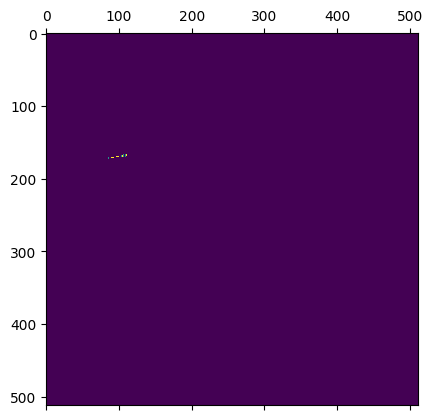

In [6]:
calc_metrics(381, verbose=True)

In [5]:
import pandas as pd

data = {
    "Pred Path":[],
    "Pred Image":[],
    "Pred Number":[],
    "Image Date":[],
    "Area (km^2)":[],
    "Centroid Lat":[],
    "Centroid Long":[],
    "Aspect Ratio":[]
}

#For every image in the preds directory, calculate all of the metrics and save them to a csv
for img_num in tqdm(range(len(os.listdir("../Dataset/test/preds/")))):
    pred_path = os.listdir("../Dataset/test/preds/")[img_num]
    pred_num = pred_path[-5]
    img_path = pred_path[:pred_path.find("_")]
    img_date = ""
    area, centroid_lat, centroid_long, aspect_ratio = calc_metrics(img_num)
    data["Pred Path"].append(pred_path)
    data["Pred Image"].append(img_path)
    data["Pred Number"].append(pred_num)
    data["Image Date"].append(img_date)
    data["Area (km^2)"].append(area)
    data["Centroid Lat"].append(centroid_lat)
    data["Centroid Long"].append(centroid_long)
    data["Aspect Ratio"].append(aspect_ratio)

df = pd.DataFrame.from_dict(data)
df.to_csv("Metrics.csv")
    
    

  6%|████▌                                                                          | 27/462 [01:18<1:21:45, 11.28s/it]C:\Users\zacha\AppData\Local\Temp\ipykernel_119384\3372304175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  asp_ratio = major_axis_length / minor_axis_length
100%|██████████████████████████████████████████████████████████████████████████████| 462/462 [4:02:14<00:00, 31.46s/it]
